# Сборный проект № 2

Описание проекта:

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

# Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Проект проходит в несколько шагов:

Шаг 1. Откройть файл с данными и изучить общую информацию

Шаг 2. Подготовка данных

Шаг 3. Изучение и проверка данных

Шаг 4. Изучение воронки событий

Шаг 5. Изучение результатов эксперимента

Вывод

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from plotly import graph_objects as graph
import math as mat
import warnings
pd.set_option('display.max_colwidth', 150)
# Сразу импортируем необходимые библиотеки

# Шаг 1

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
display(data.head())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


# Шаг 2

Переименуем столбцы и приведем к нижнему регистру. 

In [5]:
data.columns = ['event', 'device_id', 'event_timestamp', 'exp_id']

In [6]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 413


Удалим дупликаты

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

Проверим данные на пропуски

In [8]:
data.isna().sum()

event              0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64

Проверим данные на пользователей вошедшие в несколько групп

In [9]:
inter = np.intersect1d(data.query('exp_id == 246')['device_id'].unique(), data.query('exp_id == 247')['device_id'].unique())
inter

array([], dtype=int64)

In [10]:
inter = np.intersect1d(data.query('exp_id == 246')['device_id'].unique(), data.query('exp_id == 248')['device_id'].unique())
inter

array([], dtype=int64)

In [11]:
inter = np.intersect1d(data.query('exp_id == 247')['device_id'].unique(), data.query('exp_id == 248')['device_id'].unique())
inter

array([], dtype=int64)

Создадим столбец с датой

In [12]:
data['datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['datetime'].dt.date
data['date'] = pd.to_datetime(data['date'])

In [13]:
display(data.head())

,event,device_id,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event            243713 non-null  object        
 1   device_id        243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   datetime         243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


**Итог:**

Пользователей попавших в две или несколько групп нет

Пропуски и дубликаты отсутствуют

Типы данных соответствуют для дальнейшего иследования

# Шаг 3

**Посмотрим на количество событий**

In [15]:
count_data = data.shape[0]
print('Всего событий:', count_data)

Всего событий: 243713


**Проверим количество пользователей**

In [16]:
count_us = len(data['device_id'].unique())
print('Количество пользователей:', count_us)

Количество пользователей: 7551


**Среднее колличество событий на одного пользователя**

In [17]:
data.groupby('device_id').agg({'event': 'count'})['event'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

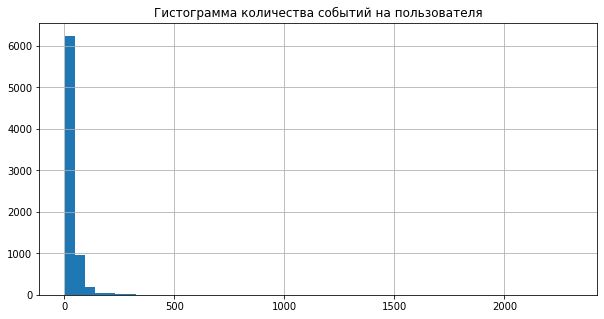

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(data.groupby('device_id').agg({'event': 'count'})['event'], bins=50)
plt.grid(True)
plt.title('Гистограмма количества событий на пользователя')
plt.show()

Cреднее количество событий - 32 на одного пользователя. 

Максимальное значение — 2307.

Медианное количество событий на одного пользователя — 20

**Посмотрим за какой временной период предоставленны данные**

In [19]:
print('Минимальная дата:', data['date'].min())
print('Максимальная дата:', data['date'].max())
data['date'].max() - data['date'].min()

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


Timedelta('13 days 00:00:00')

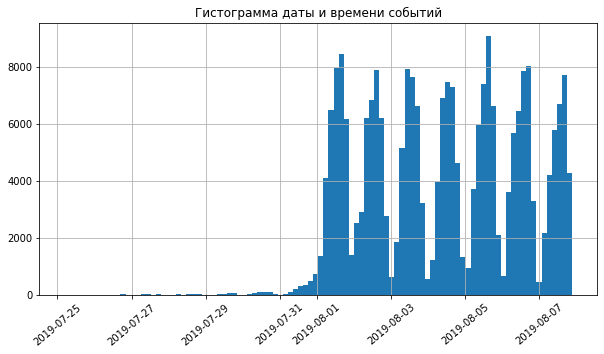

In [20]:
plt.figure(figsize=(10, 5))
plt.hist(data['datetime'], bins=100)
plt.grid(True)
plt.title('Гистограмма даты и времени событий')
plt.xticks(rotation=40)
plt.show()

Уже сейчас данные некоректны, стоить расмотреть подробнее 2019-07-31

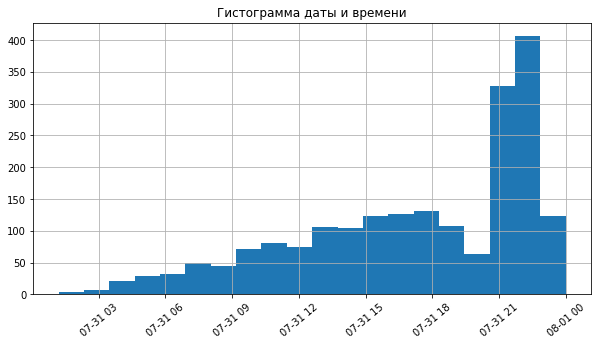

In [21]:
plt.figure(figsize=(10, 5))
plt.hist(data.query('date == "2019-07-31"')['datetime'], bins=20)
plt.grid(True)
plt.title('Гистограмма даты и времени')
plt.xticks(rotation=40)
plt.show()

Стоит взять за основу данные от 21.00 07,31. Старые данные исключить.

In [22]:
data = data[data['datetime'] >= '2019-07-31 21:00:00'].reset_index(drop=True)

In [23]:
print('Минимальная дата:', data['date'].min())
print('Максимальная дата:', data['date'].max())
data['date'].max() - data['date'].min()

Минимальная дата: 2019-07-31 00:00:00
Максимальная дата: 2019-08-07 00:00:00


Timedelta('7 days 00:00:00')

Период иследования сократился до 7 дней

С 2019-07-31 по 2019-08-07


**Проверим колличество событий и пользователй после исключения старых данных** 

In [24]:
count_data_new = data.shape[0]
print('Всего событий:', count_data_new)
print('Потеряно событий:', count_data - count_data_new)
print(f'Потеряно {round(((count_data - count_data_new) / count_data) * 100, 1)}% событий')

Всего событий: 241724
Потеряно событий: 1989
Потеряно 0.8% событий


In [25]:
count_us_new = len(data['device_id'].unique())
print('Всего пользователей:', count_us)
print('Потеряно пользователей:', count_us - count_us_new)
print(f'Потеряно {round(((count_us - count_us_new) / count_us) * 100, 1)}% пользователей')

Всего пользователей: 7551
Потеряно пользователей: 13
Потеряно 0.2% пользователей


Потери в данных незначительны, исключение старых данных не повлияло на основной массив.

**Проверим колличество пользователей в группах**

In [26]:
data.groupby('exp_id').agg({'device_id': 'nunique'}).sort_values('exp_id')

,device_id
exp_id,
246,2484
247,2517
248,2537


**Данные готовы для дальнейшего иследования:**

Данные предоставлены по всем группам. 

Старые, нерелевантные данные исключины, потери минимальны и не скажутся в дальнейшем.



# Шаг 4

**Проверим какие события представлены в данных и их количество**

In [27]:
data['event'].value_counts()

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event, dtype: int64

**Посчитваем сколько пользователей совершали каждое из этих событий, данные отсортируеи по числу пользователей. Так же определим долю пользователей, которые хоть раз совершали событие** 

In [28]:
event_count = data.groupby('event').agg({'device_id': 'nunique'}).sort_values('device_id', ascending=False).reset_index()
event_count['portion'] = ((event_count['device_id'] / count_us_new) * 100).round(1)
event_count['portion_trans'] = (event_count['device_id'].pct_change().fillna(0)+1)
event_count.style.format({'portion_trans': '{:,2%}', 'conv': '{:,2%}'})
display(event_count)

,event,device_id,portion,portion_trans
0,MainScreenAppear,7423,98.5,1.000000
1,OffersScreenAppear,4597,61.0,0.619291
2,CartScreenAppear,3736,49.6,0.812704
3,PaymentScreenSuccessful,3540,47.0,0.947537
4,Tutorial,843,11.2,0.238136


Порядок событий:

MainScreenAppear

OffersScreenAppear

CartScreenAppear

PaymentScreenSuccessful

Tutorial - по логике это событие должно быть в начале, но примим как данность, что обучение(руководство) пропускает подавляющее число пользователей, как и пользовательские соглашения. В текущию воронку Tutorial не вписывается, не стоит учитывать его.


Начиная с события MainScreenAppear при переходе к OffersScreenAppear доля  пользователей составляет 61.1, затем при переходе CartScreenAppear доля сокращается и состовляет 49.6.

**Доля добравшихся до события PaymentScreenSuccessful составлят 47.0**

**Самое большое падение доли пользователей происходит при переходе с MainScreenAppear на OffersScreenAppear**

# Шаг 5

**Проверим количество пользователей в группах в каждой экспериментальной группе**

In [29]:
exp_group = data.groupby('exp_id').agg({'device_id': 'nunique'}).sort_values('exp_id')
exp_group

,device_id
exp_id,
246,2484
247,2517
248,2537


**Для гипотез создадим переменную "ex_event" с числом уникальных пользователей прошедних события в каждой группе**

In [30]:
ex_event = data.query('event != "Tutorial"').pivot_table('device_id', index=['event'], columns=['exp_id'], aggfunc='nunique').sort_values(246, ascending=False).reset_index()
ex_event['246+247'] = ex_event[246] + ex_event[247]
ex_event.columns = ['event', '246', '247', '248', '246+247']
display(ex_event)

,event,246,247,248,246+247
0,MainScreenAppear,2450,2479,2494,4929
1,OffersScreenAppear,1542,1524,1531,3066
2,CartScreenAppear,1266,1239,1231,2505
3,PaymentScreenSuccessful,1200,1158,1182,2358


Сравним доли пользователей совершивших каждое из событий для контрольных групп 246 и 247, чтобы проверить корректность всех механизмов и расчётов

**Гипотезы**

H01 - доли уникальных пользователей, прошедших этапы воронки равны

H02 — доли уникальных пользователей, прошедших этапы воронки различны

Для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, применим поправку Бонферрони bonferroni_alpha

Чтобы попарно сравнить доли в четырех событиях для четырех групп, уровень значимости alpha делим на 16

In [31]:
alpha = 0.05
bonferroni_alpha = alpha / 16

In [32]:
def hypothesis_test(successes_1, successes_2, trials_1, trials_2, event, group_1, group_2):
    p1 = successes_1 / trials_1
    p2 = successes_2 / trials_2
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
    difference = p1 - p2
    z_value = difference / mat.sqrt(p_combined * (1 - p_combined) * (1 / trials_1 + 1 / trials_2))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие', event)
    print(f'Доля пользователей для группы номер: {group_1} — {round((successes_1 / trials_1) * 100, 1)}%')
    print(f'Доля пользователей для группы номер: {group_2} — {round((successes_2 / trials_2) * 100, 1)}%')
    print('p-значение: ', p_value)
    
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [33]:
for i in range(len(ex_event)):
    hypothesis_test(ex_event.loc[i, '246'], ex_event.loc[i, '247'], exp_group.loc[246, 'device_id'], exp_group.loc[247, 'device_id'], ex_event.loc[i, 'event'], '246', '247')

Событие MainScreenAppear
Доля пользователей для группы номер: 246 — 98.6%
Доля пользователей для группы номер: 247 — 98.5%
p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear
Доля пользователей для группы номер: 246 — 62.1%
Доля пользователей для группы номер: 247 — 60.5%
p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear
Доля пользователей для группы номер: 246 — 51.0%
Доля пользователей для группы номер: 247 — 49.2%
p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful
Доля пользователей для группы номер: 246 — 48.3%
Доля пользователей для группы номер: 247 — 46.0%
p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Групп разделены корректно, значимой разницы в долях нет. 

**Сравнение долей пользователей совершивших каждое из событий в контрольной группы "247" и экспериментальной группы с изменённым шрифтом "248"**

In [34]:
for i in range(len(ex_event)):
    hypothesis_test(ex_event.loc[i, '247'], ex_event.loc[i, '248'], exp_group.loc[247, 'device_id'], exp_group.loc[248, 'device_id'], ex_event.loc[i, 'event'], '247', '248')

Событие MainScreenAppear
Доля пользователей для группы номер: 247 — 98.5%
Доля пользователей для группы номер: 248 — 98.3%
p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear
Доля пользователей для группы номер: 247 — 60.5%
Доля пользователей для группы номер: 248 — 60.3%
p-значение:  0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear
Доля пользователей для группы номер: 247 — 49.2%
Доля пользователей для группы номер: 248 — 48.5%
p-значение:  0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful
Доля пользователей для группы номер: 247 — 46.0%
Доля пользователей для группы номер: 248 — 46.6%
p-значение:  0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Сравнение долей пользователей совершивших каждое из событий в контрольной группы "246" и экспериментальной группы с изменённым шрифтом "248"**

In [38]:
for i in range(len(ex_event)):
    hypothesis_test(ex_event.loc[i, '246'], ex_event.loc[i, '248'], exp_group.loc[246, 'device_id'], exp_group.loc[247, 'device_id'], ex_event.loc[i, 'event'], '246', '248')

Событие MainScreenAppear
Доля пользователей для группы номер: 246 — 98.6%
Доля пользователей для группы номер: 248 — 99.1%
p-значение:  0.12964615716425953
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear
Доля пользователей для группы номер: 246 — 62.1%
Доля пользователей для группы номер: 248 — 60.8%
p-значение:  0.36348863306242984
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear
Доля пользователей для группы номер: 246 — 51.0%
Доля пользователей для группы номер: 248 — 48.9%
p-значение:  0.14542737713629217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful
Доля пользователей для группы номер: 246 — 48.3%
Доля пользователей для группы номер: 248 — 47.0%
p-значение:  0.3397351400885702
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Сравнение долей пользователей совершивших каждое из событий для контрольной группы 246+247 и экспериментальной группы с изменённым шрифтом 248**

In [36]:
for i in range(len(ex_event)):
    hypothesis_test(ex_event.loc[i, '246+247'], ex_event.loc[i, '248'],
    exp_group.loc[246, 'device_id'] + exp_group.loc[247, 'device_id'], exp_group.loc[248, 'device_id'], ex_event.loc[i, 'event'], '246+247', '248')

Событие MainScreenAppear
Доля пользователей для группы номер: 246+247 — 98.6%
Доля пользователей для группы номер: 248 — 98.3%
p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear
Доля пользователей для группы номер: 246+247 — 61.3%
Доля пользователей для группы номер: 248 — 60.3%
p-значение:  0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear
Доля пользователей для группы номер: 246+247 — 50.1%
Доля пользователей для группы номер: 248 — 48.5%
p-значение:  0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful
Доля пользователей для группы номер: 246+247 — 47.2%
Доля пользователей для группы номер: 248 — 46.6%
p-значение:  0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



# Вывод

Самая большая потеря пользователей происходит при переходе с главного экрана(MainScreenAppear) на предложения(OffersScreenAppear). Для решения этой проблемы нужны тестировщики, опрос пользователей и т.д

Доля пользователей добравшихся до покупки(PaymentScreenSuccessful) равна 47%. Это хороший результат. 

По итогу А/В тестов, становится видно, что смена шрифта не оказывает значимого влияния на поведение пользователей. 
Смену шрифта стоит оставить на усмотрения ответственных лиц, дизайнеров и т.д